# Reproduction of the article's simulation

In [48]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
import random 
from scipy.stats import shapiro

# Parameters remain unchanged
X_0 = 100
K = 100
sigma = 0.01

# consider one trading day
dt = 1 / (3600 * 8 * 10)
T = 1
N = int(T / dt)
t = np.linspace(0, T, N)

alpha = 0.05
eta = 0.05

def generate_price_vectorized(sigma):
    Z = np.random.normal(size=N-1)
    X = X_0 * np.exp(np.cumsum(sigma * np.sqrt(dt) * Z - 0.5 * sigma**2 * dt))
    return np.insert(X, 0, X_0)
def delta_hedging(S, K, mat, sigma):
    d1 = (np.log(S / K) + (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))
    return norm.cdf(d1)
def option_price(S,K,mat,sigma):
    d1 = (np.log(S / K) + (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))
    d2 = (np.log(S / K) - (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))
    return (S*norm.cdf(d1) - K * norm.cdf(d2))

In [52]:
# hedging_number == 1: first hedging
# hedging_number == 2: second and third hedging
def monte_carlo_L(nb_simul,hedging_number,jump_size,alpha):
    L_list = np.zeros(nb_simul)
    tau_list = np.zeros(nb_simul)
    list_continuation = np.zeros(nb_simul)
    list_alternation = np.zeros(nb_simul)
    list_estimated_eta = np.zeros(nb_simul)
    for k in range (nb_simul):
        list_continuation[k] = 0 
        list_alternation[k] = 0
        X = generate_price_vectorized(sigma)
        L = 0
        delta = delta_hedging(X,K,T-t,sigma)
        delta_estimated = np.zeros(N)
        delta_estimated[0] = delta[0]

        tau = []

        price_with_uncertainty = np.zeros(N)
        price_with_uncertainty[0] = X_0
        last_tau_index = 0
        for i in range(1, N):
            price_change = np.abs(X[i] - price_with_uncertainty[i-1])
            if price_change >= (jump_size - 1/2 + eta) * alpha:  # Price change exceeds the threshold, update the price
                if (X[i] - X[i-1]) >= 0:
                    price_with_uncertainty[i] =  price_with_uncertainty[i-1] + alpha * jump_size
                else:
                    price_with_uncertainty[i] = price_with_uncertainty[i-1] - alpha * jump_size
                tau.append(t[i])
                delta_estimated[i] = delta[i]
                if last_tau_index!=0:
                    if price_with_uncertainty[i]==price_with_uncertainty[last_tau_index-1]:
                        list_alternation[k] += 1 
                    else:
                        list_continuation[k] += 1 
                last_tau_index = i
                
                
            else:
                price_with_uncertainty[i] = price_with_uncertainty[i-1]  # Keep the price at the last level
                delta_estimated[i] = delta_estimated[i-1]
            if hedging_number == 1:
                L += (delta[i-1] - delta_estimated[i-1]) * (X[i] -X[i-1])
            elif hedging_number == 2:
                L += delta[i-1] * (X[i] -X[i-1]) - delta_estimated[i-1] * (price_with_uncertainty[i] - price_with_uncertainty[i-1])
        L_list[k] = L
        tau_list[k] = len(tau)
        list_estimated_eta[k] = list_continuation[k]/(list_alternation[k]*2)
        
    moy_tau = np.mean(tau_list)
    std_tau = np.std(tau_list)
    moy_alt = np.mean(list_alternation)
    moy_cont = np.mean(list_continuation)
    estimated_eta = np.mean(list_estimated_eta)
    return L_list, [moy_tau,std_tau,moy_alt,moy_cont,estimated_eta]

In [53]:
res_1 = monte_carlo_L(1000,1,1,0.05)
res_2 = monte_carlo_L(1000,2,1,0.05)
res_3 = monte_carlo_L(1000,2,5,0.05)

/var/folders/94/d2sps6fd06xg7r7t72lt5r800000gn/T/ipykernel_46298/2539598976.py:27: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))


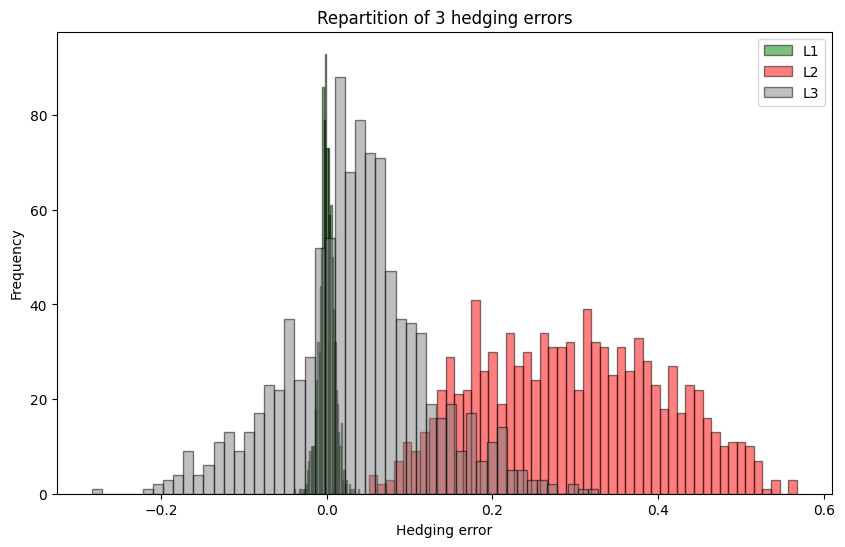

In [12]:
plt.figure(figsize=(10,6))
plt.hist(res_1[0],bins = 50,color='green',alpha=0.5, edgecolor='black',label = 'L1')
plt.hist(res_2[0],bins = 50,color='red',alpha=0.5, edgecolor='black',label = 'L2')
plt.hist(res_3[0],bins = 50,color='gray',alpha=0.5, edgecolor='black',label = 'L3')
plt.legend()
plt.xlabel('Hedging error')
plt.ylabel('Frequency')
plt.title('Repartition of 3 hedging errors')
plt.show()

In [15]:
print("Every price move rebalancing:")
print("-average of number rebalancing " + str(res_1[1][0]))
print("-standard deviation of number rebalancing " + str(round(res_1[1][1],3)))

print("5 ticks rebalancing:")
print("-average of number rebalancing " + str(res_3[1][0]))
print("-standard deviation of number rebalancing " + str(round(res_3[1][1],3)))

Every price move rebalancing:
-average of number rebalancing 2784.485
-standard deviation of number rebalancing 83.306
5 ticks rebalancing:
-average of number rebalancing 19.104
-standard deviation of number rebalancing 3.562


# Analysis of the simulation and modified simulations

## Estimation of eta using the number of continuations and alternations

In [20]:
eta_estimated = res_1[1][3]/(2*res_1[1][2])
print("The value of the estimated eta is " + str(round(eta_estimated,4)) + " and the real value of eta is " + str(eta))

The value of the estimated eta is 0.0717 and the real value of eta is 0.05


## Effect of difference between the number of continuations and alternations on the hedging error of L2

In [54]:
def effect_difference_alt_cont(nb_points):
    x = []
    y = []
    y2 = []
    for i in range(1,nb_points+1):
        result = monte_carlo_L(100,2,i,0.05)
        y.append(np.sum(result[0])**2)
        y2.append(np.std(result[0]))
        x.append(abs(result[1][2]-result[1][3]))
    return x,y,y2

In [55]:
x_diff,y_diff,y_diff_2 = effect_difference_alt_cont(7)

/var/folders/94/d2sps6fd06xg7r7t72lt5r800000gn/T/ipykernel_46298/2539598976.py:27: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))


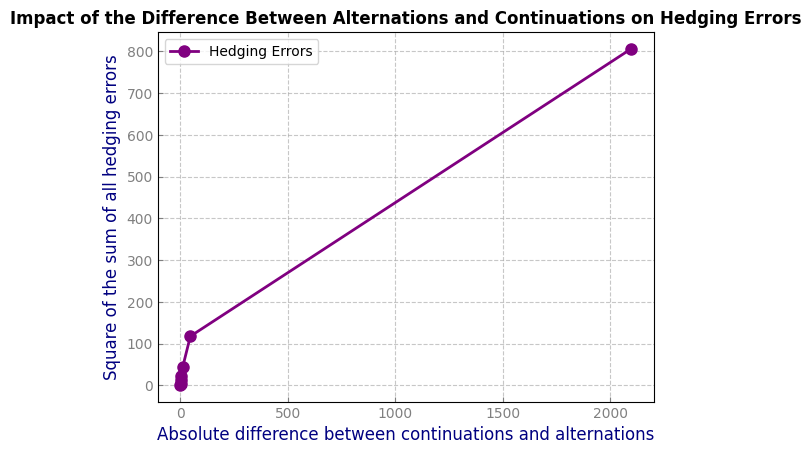

In [201]:
plt.plot(x_diff, y_diff, color='purple', marker='o', linestyle='-', linewidth=2, markersize=8, label='Hedging Errors')
plt.ylabel('Square of the sum of all hedging errors', fontsize=12, color='navy')
plt.xlabel('Absolute difference between continuations and alternations', fontsize=12, color='navy')
plt.title('Impact of the difference between continuations and alternations on quadratic errors', fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)
plt.tick_params(axis='both', which='both', direction='in', color='gray', labelcolor='gray', labelsize=10)
plt.show()

## Computation of L1 using the benchmark frictionless hedging strategy

In [11]:
# L1 With the benchmark frictionless strategy
def monte_carlo_L1_benchmark_strat(nb_simul,alpha):
    L_1_list = np.zeros(nb_simul)
    tau_list = np.zeros(nb_simul)
    for k in range (nb_simul):
        print(k)
        X = generate_price_vectorized(sigma)
        L_1 = 0
        delta = delta_hedging(X,K,T-t,sigma)
        delta_estimated = np.zeros(N)
        delta_estimated[0] = delta[0]

        tau = []

        price_with_uncertainty = np.zeros(N)
        price_with_uncertainty[0] = X_0
        
        
        for i in range(1, N):
            price_change = np.abs(X[i] - price_with_uncertainty[i-1])
            if price_change >= (1/2 + eta) * alpha:  # Price change exceeds the threshold, update the price
                if (X[i] - X[i-1]) >= 0:
                    price_with_uncertainty[i] =  price_with_uncertainty[i-1] + alpha
                else:
                    price_with_uncertainty[i] = price_with_uncertainty[i-1] - alpha
                tau.append(t[i])
                delta_estimated[i] = delta[i]
                
            else:
                price_with_uncertainty[i] = price_with_uncertainty[i-1]  # Keep the price at the last level
                delta_estimated[i] = delta_estimated[i-1]
            L_1 += - delta_estimated[i-1] * (X[i] -X[i-1])
        payoff = 0 
        if (X[-1] - K) > 0:
            payoff = X[-1] - K
        L_1 += payoff - option_price(X_0,K,T,sigma)
        L_1_list[k] = L_1
        tau_list[k] = len(tau)
    moy_tau = np.mean(tau_list)
    return L_1_list, moy_tau

In [56]:
res_benchmark = monte_carlo_L1_benchmark_strat(1000,0.05)

0


/var/folders/94/d2sps6fd06xg7r7t72lt5r800000gn/T/ipykernel_46298/2539598976.py:27: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))


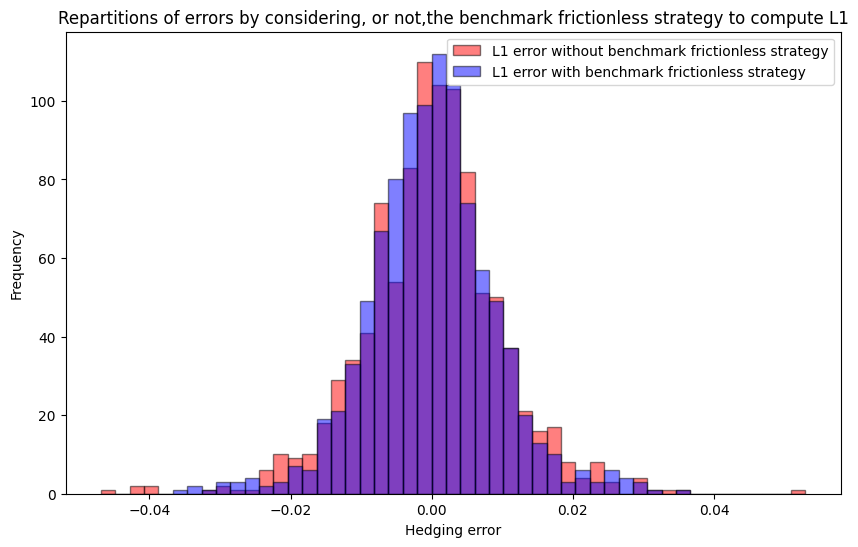

In [19]:
bins = np.linspace(min(min(res_benchmark[0]), min(res_1[0])),max(max(res_benchmark[0]), max(res_1[0])), 50)
plt.figure(figsize=(10, 6))
plt.hist(res_1[:-1],bins,color='red',edgecolor='black',alpha=0.5,label='L1 error without benchmark frictionless strategy')
plt.hist(res_benchmark[:-1],bins,color='blue', edgecolor='black',alpha=0.5,label='L1 error with benchmark frictionless strategy')
plt.legend(loc='upper right')
plt.title('Repartitions of errors by considering, or not,the benchmark frictionless strategy to compute L1')
plt.xlabel('Hedging error')
plt.ylabel('Frequency')
plt.show()

In [15]:
print('Quadratic sum of the error without benchmark frictionless strategy: ' + str(round(np.sum(res_1[:-1])**2,5)))
print('Quadratic sum of the error with benchmark frictionless strategy: ' + str(round(np.sum(res_benchmark[:-1])**2,5)))
print('The absolute difference of these errors is equal to ' + str(abs(round(np.sum(res_1[:-1])**2 - np.sum(res_benchmark[:-1])**2,5))))
print('The absolute difference of standard deviation is equal to ' + str(abs(round(np.std(res_1[0])- np.std(res_benchmark[0]),10))))
print('The small difference can be explained by the approximation of the integral in the case without the benchmark frictionless strategy.')

Quadratic sum of the error without benchmark frictionless strategy: 0.0016
Quadratic sum of the error with benchmark frictionless strategy: 0.00267
The absolute difference of these errors is equal to 0.00107
The absolute difference of standard deviation is equal to 0.0007666852
The small difference can be explained by the approximation of the integral in the case without the benchmark frictionless strategy.


## Exogenous rebalancing time for L1

We fix $\tau_i = i\alpha T$, and $t_i = \frac{1}{(3600*10*8)}$ then for our values of $\alpha$ and $T$ we have that $\frac{\tau_i}{t_i} = 720$. So we have to fix these 400 rebalancing times.

In [20]:
def L1_exogenous_reb_time(nb_simul,alpha):
    L_list = np.zeros(nb_simul)
    tau_list = np.zeros(nb_simul)
    for k in range (nb_simul):
        X = generate_price_vectorized(sigma)
        L = 0
        delta = delta_hedging(X,K,T-t,sigma)
        delta_estimated = np.zeros(N)
        delta_estimated[0] = delta[0]

        tau = []

        price_with_uncertainty = np.zeros(N)
        price_with_uncertainty[0] = X_0
        
        for i in range(1, N):
            if i % 720 == 719:
                price_with_uncertainty[i] = round(X[i]/alpha) * alpha 
                tau.append(t[i])
                delta_estimated[i] = delta[i]
            else:
                price_with_uncertainty[i] = price_with_uncertainty[i-1]  # Keep the price at the last level
                delta_estimated[i] = delta_estimated[i-1]
            L += (delta[i-1] - delta_estimated[i-1]) * (X[i] -X[i-1])
        L_list[k] = L
        tau_list[k] = len(tau)
    moy_tau = np.mean(tau_list)
    std_tau = np.std(tau_list)
    return L_list, [moy_tau,std_tau]

In [21]:
res_exogenous = L1_exogenous_reb_time(1000,0.05)

/var/folders/94/d2sps6fd06xg7r7t72lt5r800000gn/T/ipykernel_46298/2539598976.py:27: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))


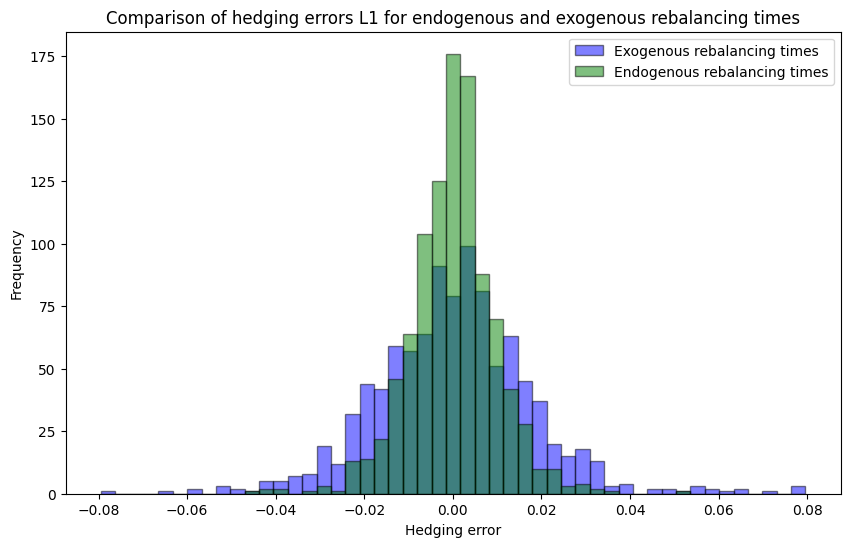

In [22]:
bins = np.linspace(min(min(res_exogenous[0]), min(res_1[0])),max(max(res_exogenous[0]), max(res_1[0])), 50)
plt.figure(figsize=(10,6))
plt.hist(res_exogenous[0],bins,color='blue',alpha=0.5, edgecolor='black',label='Exogenous rebalancing times')
plt.hist(res_1[0],bins,color='green',alpha=0.5, edgecolor='black',label='Endogenous rebalancing times')
plt.legend(loc='upper right')
plt.xlabel('Hedging error')
plt.ylabel('Frequency')
plt.title('Comparison of hedging errors L1 for endogenous and exogenous rebalancing times')
plt.show()

In [27]:
print('In case of endogenous random times, we find a quadratric sum for the hedging error equal to: ' + str(np.sum(res_1[:-1])**2))
print('In case of exogenous random times, we find a quadratric sum for the hedging error equal to: ' +str(np.sum(res_exogenous[:-1])**2))

In case of endogenous random times, we find a quadratric sum for the hedging error equal to: 0.14689482664477754
In case of exogenous random times, we find a quadratric sum for the hedging error equal to: 0.015646957524887126


We confirm that $f_T = T = 1$ because $\alpha^2 N_{\alpha, T} = (0.05)^2 * 400 = 1$ and we know that this quantity converges to $f_T$ when $\alpha$ is small enough.

In [65]:
abs(0.14689482664477754 -0.015646957524887126)

0.13124786911989042

## New parameters

### New time-step and effect on the estimator of $\eta$

In [58]:
dt = 1 / (3600 * 8 * 10 *50)
T = 1
N = int(T / dt)
t = np.linspace(0, T, N)

res_1_smaller_step = monte_carlo_L(1,1,1,0.05)

/var/folders/94/d2sps6fd06xg7r7t72lt5r800000gn/T/ipykernel_46298/2539598976.py:27: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))


In [56]:
eta_estimated_smaller_step = res_1_smaller_step[1][3]/(2*res_1_smaller_step[1][2])
print("The value of the estimated eta is " + str(round(eta_estimated_smaller_step,4)) + " and the real value of eta is " + str(eta))

The value of the estimated eta is 0.0518 and the real value of eta is 0.05


With a smaller step size, we find a more accurate estimation for $\eta$.

### Non-constant volatility 

$\sigma_{t}=0.01 + 0.005 cos(2\pi t - 0.5)$

In [57]:
dt = 1 / (3600 * 8 * 10)
T = 1
N = int(T / dt)
t = np.linspace(0, T, N)

In [63]:
def non_constant_volatility_monte_carlo(nb_simul,hedging_number,jump_size,alpha):
    L_list = np.zeros(nb_simul)
    tau_list = np.zeros(nb_simul)
    list_continuation = np.zeros(nb_simul)
    list_alternation = np.zeros(nb_simul)
    list_estimated_eta = np.zeros(nb_simul)
    sigma_list = 0.01 + 0.005*np.cos(2*np.pi*t-0.5)
    for k in range (nb_simul):
        list_continuation[k] = 0 
        list_alternation[k] = 0
        X = generate_price_vectorized(sigma_list[1:])
        L = 0
        delta = delta_hedging(X,K,T-t,sigma_list)
        delta_estimated = np.zeros(N)
        delta_estimated[0] = delta[0]

        tau = []

        price_with_uncertainty = np.zeros(N)
        price_with_uncertainty[0] = X_0
        last_tau_index = 0
        for i in range(1, N):
            price_change = np.abs(X[i] - price_with_uncertainty[i-1])
            if price_change >= (jump_size - 1/2 + eta) * alpha:  # Price change exceeds the threshold, update the price
                if (X[i] - X[i-1]) >= 0:
                    price_with_uncertainty[i] =  price_with_uncertainty[i-1] + alpha * jump_size
                else:
                    price_with_uncertainty[i] = price_with_uncertainty[i-1] - alpha * jump_size
                tau.append(t[i])
                delta_estimated[i] = delta[i]
                if last_tau_index!=0:
                    if price_with_uncertainty[i]==price_with_uncertainty[last_tau_index-1]:
                        list_alternation[k] += 1 
                    else:
                        list_continuation[k] += 1 
                last_tau_index = i
                
                
            else:
                price_with_uncertainty[i] = price_with_uncertainty[i-1]  # Keep the price at the last level
                delta_estimated[i] = delta_estimated[i-1]
            if hedging_number == 1:
                L += (delta[i-1] - delta_estimated[i-1]) * (X[i] -X[i-1])
            elif hedging_number == 2:
                L += delta[i-1] * (X[i] -X[i-1]) - delta_estimated[i-1] * (price_with_uncertainty[i] - price_with_uncertainty[i-1])
        L_list[k] = L
        tau_list[k] = len(tau)
        list_estimated_eta[k] = list_continuation[k]/(list_alternation[k]*2)
        
    moy_tau = np.mean(tau_list)
    std_tau = np.std(tau_list)
    moy_alt = np.mean(list_alternation)
    moy_cont = np.mean(list_continuation)
    estimated_eta = np.mean(list_estimated_eta)
    return L_list, [moy_tau,std_tau,moy_alt,moy_cont,estimated_eta]

In [64]:
res_L1_no_cst_vol = non_constant_volatility_monte_carlo(1000,1,1,0.05)

/var/folders/94/d2sps6fd06xg7r7t72lt5r800000gn/T/ipykernel_46298/2539598976.py:27: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (sigma**2 / 2) * mat) / (sigma * np.sqrt(mat))


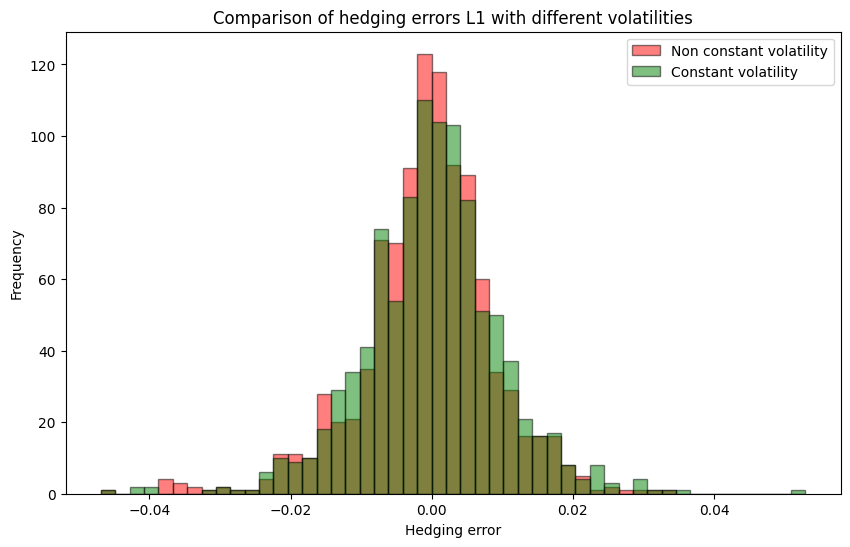

In [50]:
bins = np.linspace(min(min(res_L1_no_cst_vol[0]), min(res_1[0])),max(max(res_L1_no_cst_vol[0]), max(res_1[0])), 50)
plt.figure(figsize=(10,6))
plt.hist(res_L1_no_cst_vol[0],bins,color="red",edgecolor="black",alpha=0.5,label = 'Non constant volatility')
plt.hist(res_1[0],bins,color="green",edgecolor="black",alpha=0.5, label='Constant volatility')
plt.legend(loc='upper right')
plt.xlabel('Hedging error')
plt.ylabel('Frequency')
plt.title('Comparison of hedging errors L1 with different volatilities')
plt.show()

## Asymptotic standard deviation of L1

We want to reproduce a result related to the asymptotic value of L1: our idea is to consider the first method of hedging (rebalancing every time the price move) and changing the value of $L_i$.

However, by doing this, we're not only changing the value of $N_{\alpha ,T}$ but also the value of $\mu _4$.

In [39]:
def proportionality_mu_L(nb_points):
    x = np.zeros(nb_points)
    y = np.zeros(nb_points)
    mu_4 =  (1-1+2*eta)*(1**2 -1 +2*eta*1 + 4*eta**2-4*eta +1)
    x[0] = alpha**2 * mu_4 
    y[0] = res_1[0].std()**2
    for i in range (2,nb_points+1):
        res = monte_carlo_L(1000,1,i,0.05)
        std = np.std(res[0])
        mu_4 =  i*(i-1+2*eta)*(i**2 -i +2*eta*i + 4*eta**2-4*eta +1)
        x[i-1] = alpha**2 * mu_4
        y[i-1] = res[0].std()**2
    return x,y 

In [60]:
x_prop,y_prop = proportionality_mu_L(7)

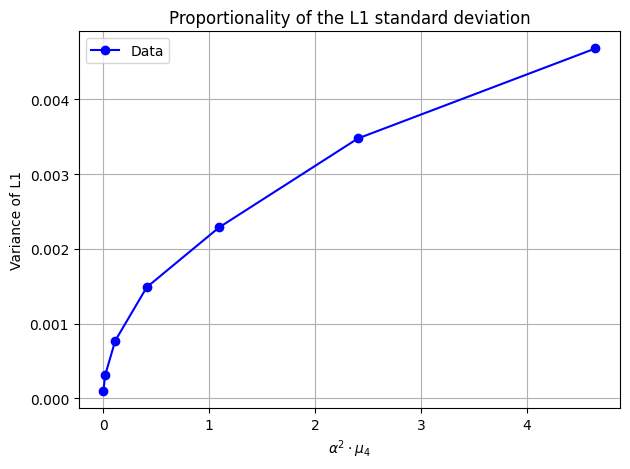

In [47]:
plt.plot(x_prop, y_prop, marker='o', linestyle='-', color='b', label='Data')

plt.xlabel(r'$\alpha^2 \cdot \mu_4$')  
plt.ylabel('Variance of L1')
plt.title('Proportionality of the L1 standard deviation')
plt.grid(True) 
plt.legend()  

plt.tight_layout()  
plt.show()